# Wine Reviews Analysis with Early Exploratory Data Analysis and VADER Sentiment

This notebook analyzes wine reviews by first performing early exploratory analysis (review length, points distribution, length vs. points, and word frequency/word cloud analysis) before proceeding with text cleaning, sentiment analysis using VADER, and further insights.

In [21]:
%pip install pandas matplotlib seaborn nltk openpyxl scipy statsmodels wordcloud scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import pearsonr
import statsmodels.api as sm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords', quiet=True)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lijianing/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lijianing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lijianing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lijianing/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Loading and Exploration

Load the wine reviews dataset and inspect its structure.

In [23]:
file_path = 'winemag-data-130k-v2.csv'
df = pd.read_csv(file_path)

print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Head:
   id   country                                        description  \
0   0     Italy  Aromas include tropical fruit, broom, brimston...   
1   1  Portugal  This is ripe and fruity, a wine that is smooth...   
2   2        US  Tart and snappy, the flavors of lime flesh and...   
3   3        US  Pineapple rind, lemon pith and orange blossom ...   
4   4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       K

## Early Exploratory Analysis - Review Length

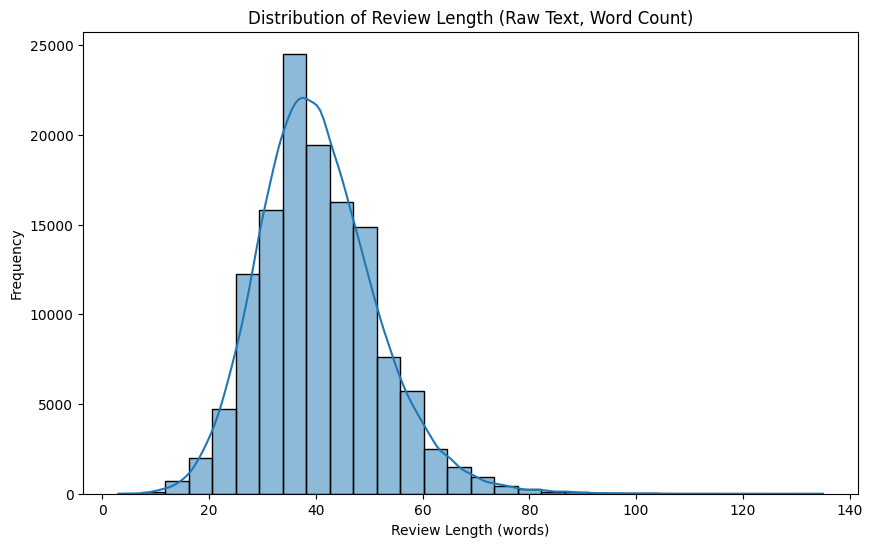

Raw Review Length Summary:
count    129971.000000
mean         40.379615
std          11.111982
min           3.000000
25%          33.000000
50%          39.000000
75%          47.000000
max         135.000000
Name: raw_review_length, dtype: float64


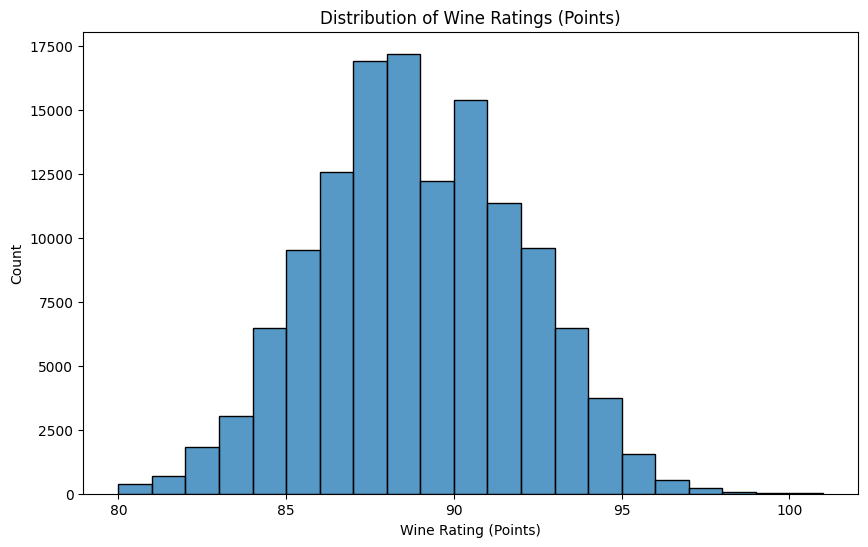

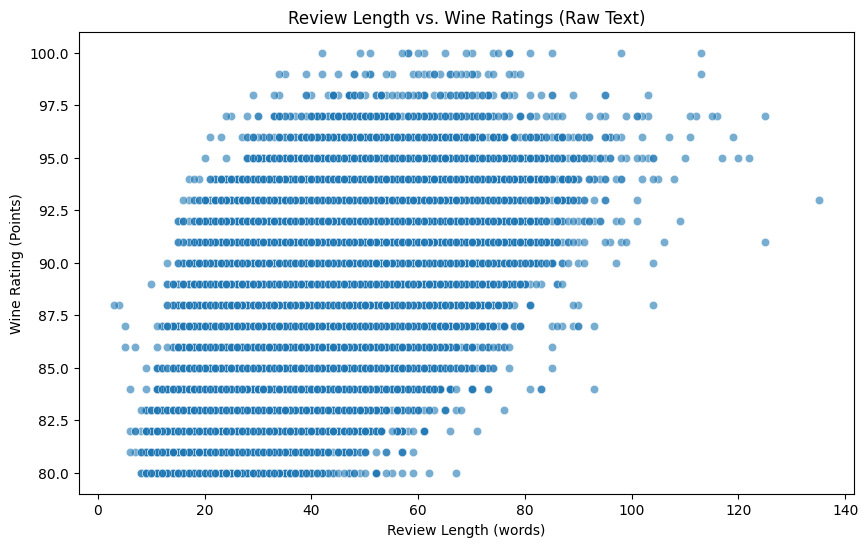

Top 20 words in raw reviews:
          word  frequency
30472     wine      80359
10853  flavors      62796
11482    fruit      49939
1953    aromas      39639
19599   palate      38523
805    acidity      35003
10686   finish      34974
27238  tannins      30878
8841     drink      30323
5501    cherry      29322
3238     black      29024
23033     ripe      27377
22296      red      21784
25656    spice      19233
18660    notes      19047
18787      oak      17769
11383    fresh      17527
22928     rich      17466
8893       dry      17222
3059     berry      16983


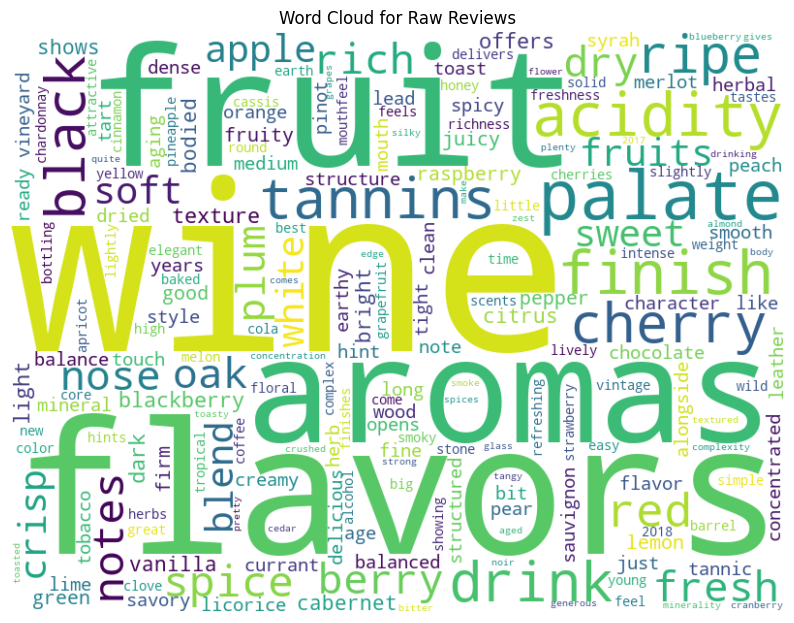

In [24]:
# Ensure the 'description' column exists and drop missing values
df = df.dropna(subset=['description'])
df['description'] = df['description'].str.strip()

# --- Review Length Analysis (Raw Text) ---
# Calculate review length in words from the raw description
df['raw_review_length'] = df['description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(df['raw_review_length'], bins=30, kde=True)
plt.title("Distribution of Review Length (Raw Text, Word Count)")
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.show()

print("Raw Review Length Summary:")
print(df['raw_review_length'].describe())

# --- Points Distribution Analysis ---
plt.figure(figsize=(10,6))
sns.histplot(df['points'], bins=range(int(df['points'].min()), int(df['points'].max())+2), kde=False)
plt.title("Distribution of Wine Ratings (Points)")
plt.xlabel("Wine Rating (Points)")
plt.ylabel("Count")
plt.show()

# --- Length vs. Points Analysis ---
plt.figure(figsize=(10,6))
sns.scatterplot(x='raw_review_length', y='points', data=df, alpha=0.6)
plt.title("Review Length vs. Wine Ratings (Raw Text)")
plt.xlabel("Review Length (words)")
plt.ylabel("Wine Rating (Points)")
plt.show()

# --- Word Frequency Analysis and Word Cloud (Raw Text) ---
# For a quick word frequency analysis, we can use a basic CountVectorizer on raw text.
vectorizer = CountVectorizer(stop_words='english')
raw_matrix = vectorizer.fit_transform(df['description'])
raw_counts = raw_matrix.sum(axis=0).A1
raw_vocab = vectorizer.get_feature_names_out()
raw_freq_df = pd.DataFrame({'word': raw_vocab, 'frequency': raw_counts}).sort_values(by='frequency', ascending=False)

print("Top 20 words in raw reviews:")
print(raw_freq_df.head(20))

# Generate a word cloud from the raw frequency dictionary
raw_word_dict = dict(zip(raw_freq_df['word'], raw_freq_df['frequency']))
wordcloud_raw = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(raw_word_dict)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Raw Reviews")
plt.show()

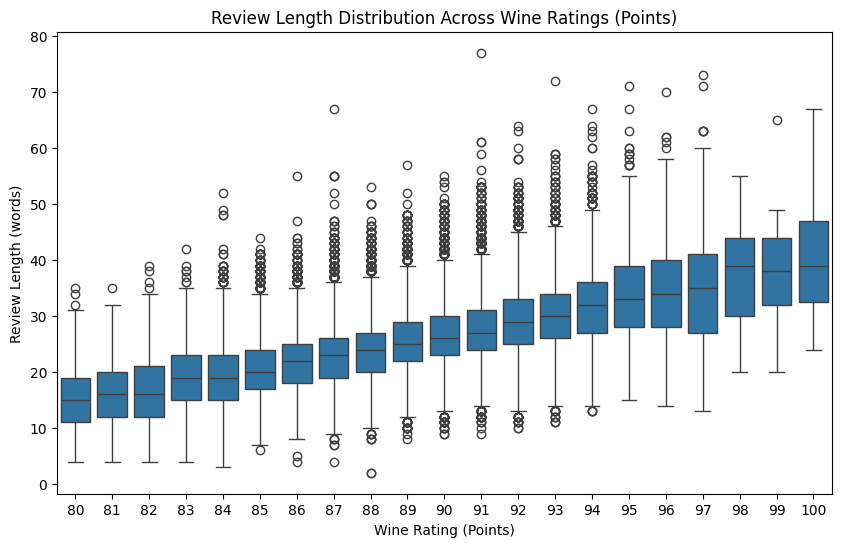

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(x='points', y='review_length', data=df)
plt.title("Review Length Distribution Across Wine Ratings (Points)")
plt.xlabel("Wine Rating (Points)")
plt.ylabel("Review Length (words)")
plt.show()

## Advanced Text Preprocessing

In [25]:
def preprocess_text(text):
    """
    Tokenizes the input text, converts it to lowercase, removes stopwords and punctuation,
    filters out tokens with length <= 2, and applies lemmatization using NLTK's WordNetLemmatizer.
    """
    stop_words = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the text using NLTK's word_tokenize
    word_tokens = word_tokenize(text)
    
    # Process tokens: lowercase, remove stopwords/punctuation, and lemmatize
    filtered_tokens = [
        lemmatizer.lemmatize(token.lower()) 
        for token in word_tokens 
        if token.lower() not in stop_words and token not in punctuation_set and len(token) > 2
    ]
    return " ".join(filtered_tokens)

In [26]:
# For further analysis, convert the raw descriptions to lowercase and strip spaces (if not already)
df['description'] = df['description'].str.lower().str.strip()

# Create a new column with the preprocessed (clean) description
df['clean_description'] = df['description'].apply(preprocess_text)

# Preview the original and preprocessed text
print(df[['description', 'clean_description']].head())

                                         description  \
0  aromas include tropical fruit, broom, brimston...   
1  this is ripe and fruity, a wine that is smooth...   
2  tart and snappy, the flavors of lime flesh and...   
3  pineapple rind, lemon pith and orange blossom ...   
4  much like the regular bottling from 2012, this...   

                                   clean_description  
0  aroma include tropical fruit broom brimstone d...  
1  ripe fruity wine smooth still structured firm ...  
2  tart snappy flavor lime flesh rind dominate gr...  
3  pineapple rind lemon pith orange blossom start...  
4  much like regular bottling 2012 come across ra...  


## Sentiment Analysis using VADER

Compute the compound sentiment score for each review based on the cleaned description.

In [27]:
# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    return vader_analyzer.polarity_scores(text)['compound']

# Compute VADER sentiment scores based on the clean description
df['vader_sentiment'] = df['clean_description'].apply(get_vader_sentiment)

print("Sample VADER Sentiment Scores:")
print(df[['clean_description', 'vader_sentiment']].head())

Sample VADER Sentiment Scores:
                                   clean_description  vader_sentiment
0  aroma include tropical fruit broom brimstone d...           0.1531
1  ripe fruity wine smooth still structured firm ...           0.6486
2  tart snappy flavor lime flesh rind dominate gr...          -0.1280
3  pineapple rind lemon pith orange blossom start...           0.3400
4  much like regular bottling 2012 come across ra...           0.8176


Sentiment Category Distribution:
sentiment_category
Positive    107276
Neutral      14105
Negative      8590
Name: count, dtype: int64


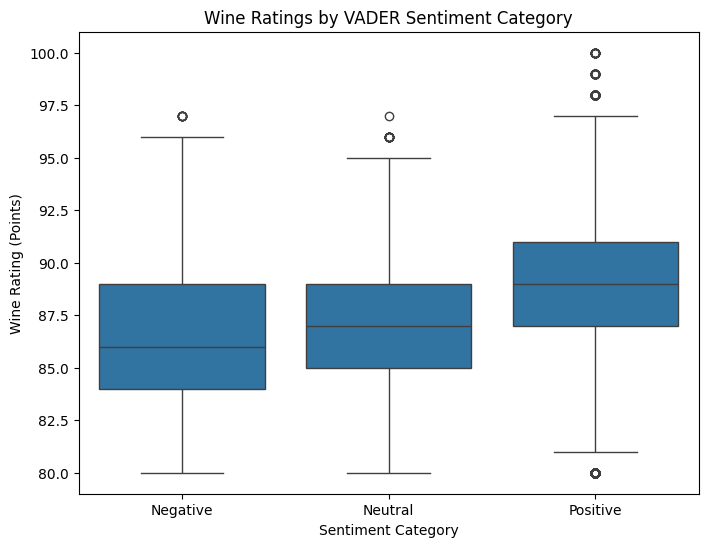

In [28]:
# Categorize sentiment into Positive, Neutral, and Negative based on VADER compound scores
def interpret_sentiment(compound):
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Create a new column with sentiment labels
df['sentiment_category'] = df['vader_sentiment'].apply(interpret_sentiment)

# Show the distribution of sentiment categories
print("Sentiment Category Distribution:")
print(df['sentiment_category'].value_counts())

# Visualize wine ratings (points) by sentiment category using a boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment_category', y='points', data=df, order=["Negative", "Neutral", "Positive"])
plt.title("Wine Ratings by VADER Sentiment Category")
plt.xlabel("Sentiment Category")
plt.ylabel("Wine Rating (Points)")
plt.show()

In [29]:
# Compute Pearson correlation between VADER sentiment and wine ratings (points)
corr, p_value = pearsonr(df['vader_sentiment'], df['points'])
print("Pearson Correlation (VADER Sentiment vs. Points):", corr)
print("p-value:", p_value)

# Fit a linear regression model to further test significance
X = sm.add_constant(df['vader_sentiment'])  # add constant term for intercept
model = sm.OLS(df['points'], X).fit()
print(model.summary())

Pearson Correlation (VADER Sentiment vs. Points): 0.31355239356947895
p-value: 0.0
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                 1.417e+04
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:38:53   Log-Likelihood:            -3.2219e+05
No. Observations:              129971   AIC:                         6.444e+05
Df Residuals:                  129969   BIC:                         6.444e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## Additional Visualizations

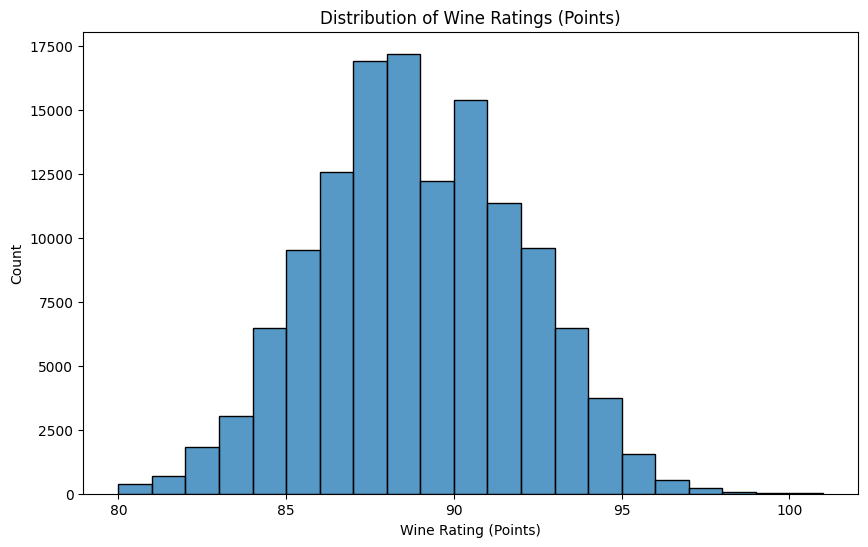

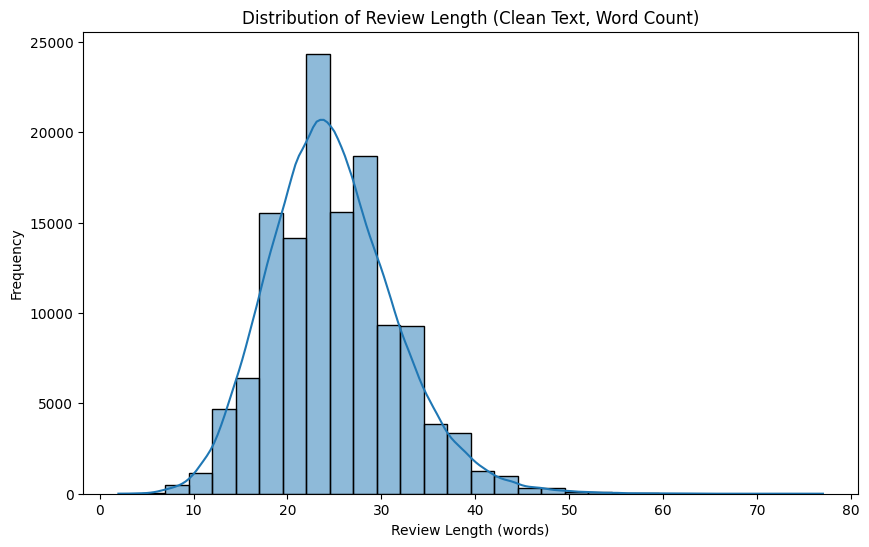

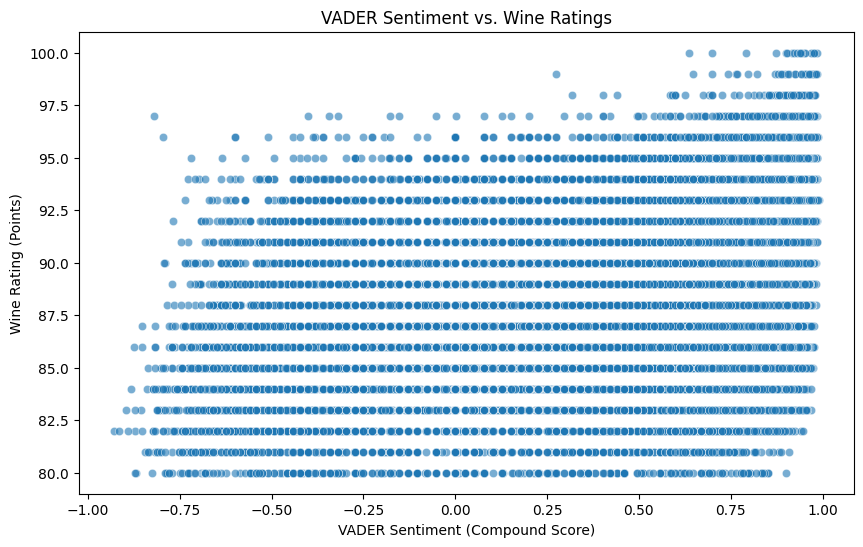

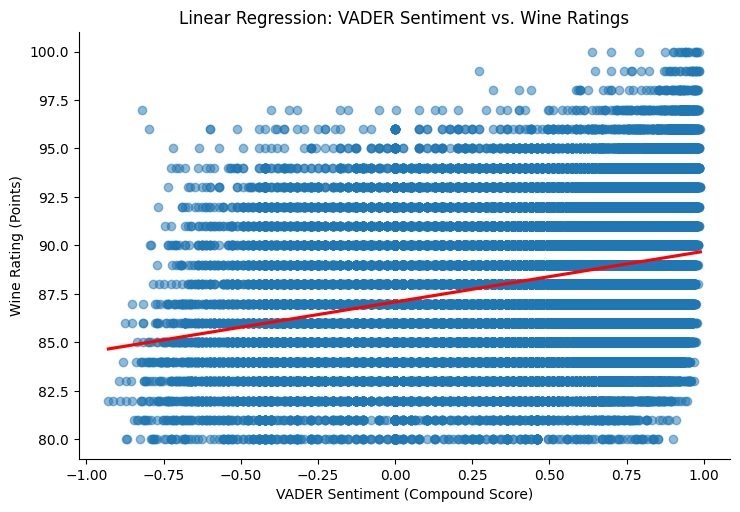

In [30]:
# Points Distribution Visualization (again, for clarity)
plt.figure(figsize=(10,6))
sns.histplot(df['points'], bins=range(int(df['points'].min()), int(df['points'].max())+2), kde=False)
plt.title("Distribution of Wine Ratings (Points)")
plt.xlabel("Wine Rating (Points)")
plt.ylabel("Count")
plt.show()

# Review Length Analysis using preprocessed text
df['review_length'] = df['clean_description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Distribution of Review Length (Clean Text, Word Count)")
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: VADER Sentiment vs. Wine Ratings
plt.figure(figsize=(10,6))
sns.scatterplot(x='vader_sentiment', y='points', data=df, alpha=0.6)
plt.title("VADER Sentiment vs. Wine Ratings")
plt.xlabel("VADER Sentiment (Compound Score)")
plt.ylabel("Wine Rating (Points)")
plt.show()

# Linear Regression Plot with red regression line
sns.lmplot(x='vader_sentiment', y='points', data=df, aspect=1.5,
           scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title("Linear Regression: VADER Sentiment vs. Wine Ratings")
plt.xlabel("VADER Sentiment (Compound Score)")
plt.ylabel("Wine Rating (Points)")
plt.show()

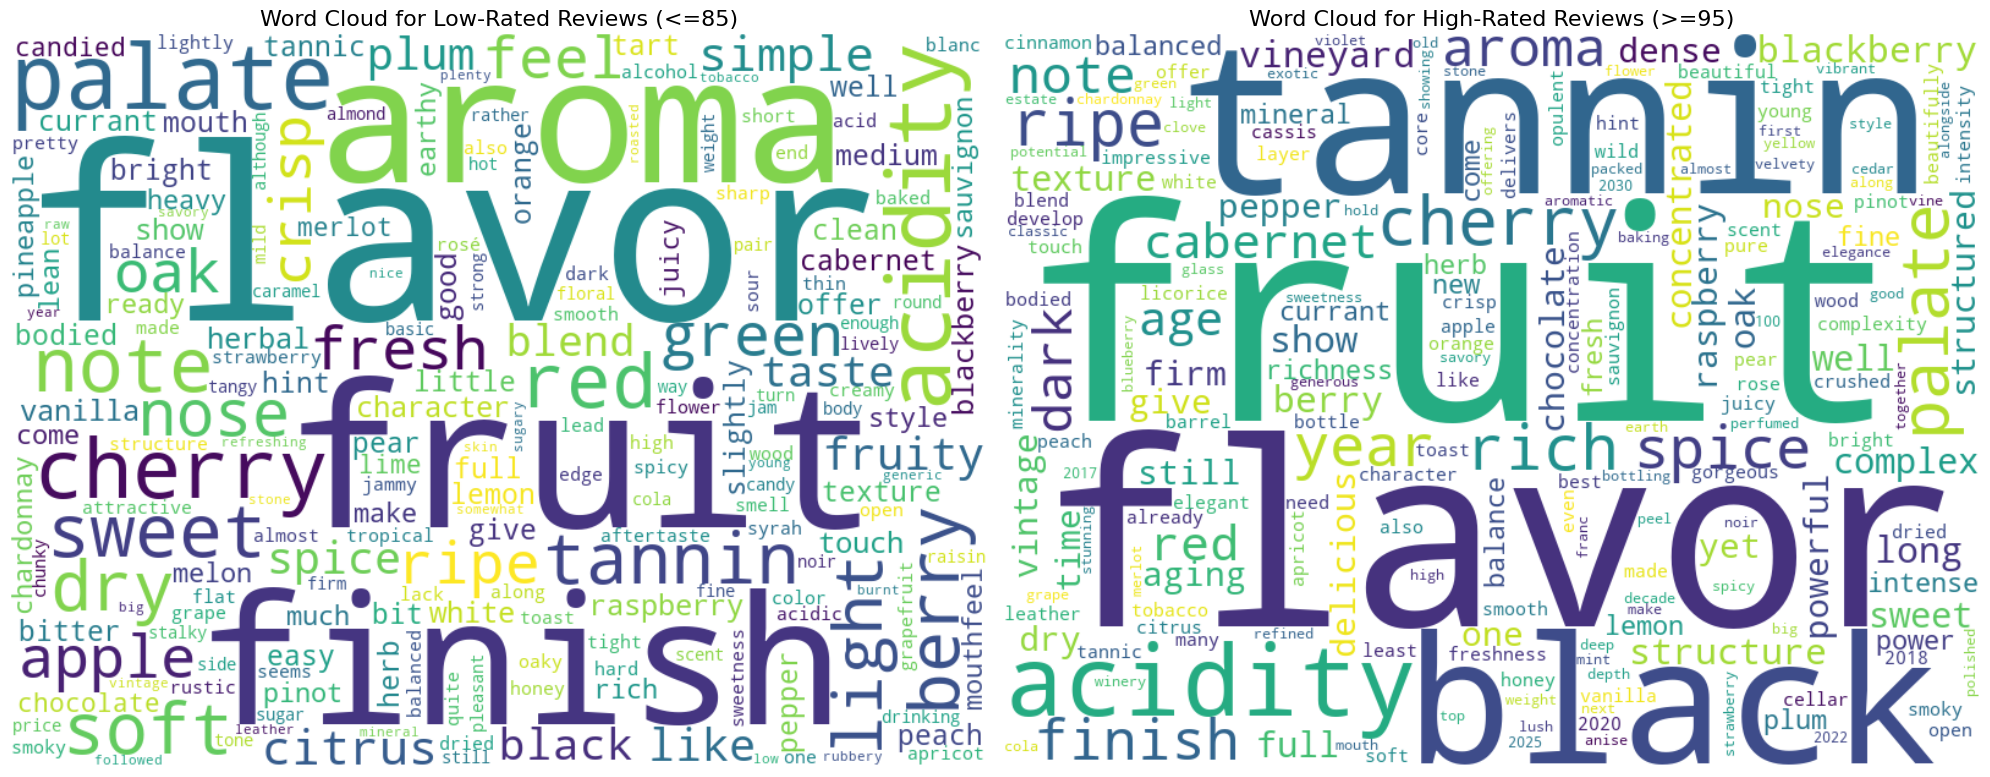

In [31]:
# Create two groups: low-rated (points <= 85) and high-rated (points >= 95)
low_df = df[df['points'] <= 85]
high_df = df[df['points'] >= 95]

# Use CountVectorizer on the clean description to compute word frequencies
vectorizer_low = CountVectorizer()
low_matrix = vectorizer_low.fit_transform(low_df['clean_description'])
low_counts = low_matrix.sum(axis=0).A1
low_vocab = vectorizer_low.get_feature_names_out()
low_freq_df = pd.DataFrame({'word': low_vocab, 'frequency': low_counts}).sort_values(by='frequency', ascending=False)

vectorizer_high = CountVectorizer()
high_matrix = vectorizer_high.fit_transform(high_df['clean_description'])
high_counts = high_matrix.sum(axis=0).A1
high_vocab = vectorizer_high.get_feature_names_out()
high_freq_df = pd.DataFrame({'word': high_vocab, 'frequency': high_counts}).sort_values(by='frequency', ascending=False)

# Define irrelevant words to remove (as determined from our discussion)
irrelevant_words = {"wine", "flavors", "drink", "notes", "years", "great"}

# Create frequency dictionaries and filter out the irrelevant words
low_word_dict = dict(zip(low_freq_df['word'], low_freq_df['frequency']))
high_word_dict = dict(zip(high_freq_df['word'], high_freq_df['frequency']))

low_word_dict_filtered = {word: freq for word, freq in low_word_dict.items() if word not in irrelevant_words}
high_word_dict_filtered = {word: freq for word, freq in high_word_dict.items() if word not in irrelevant_words}

# Generate word clouds using the filtered dictionaries
wordcloud_low = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(low_word_dict_filtered)
wordcloud_high = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(high_word_dict_filtered)

# Plot word clouds side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_low, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud for Low-Rated Reviews (<=85)", fontsize=16)

axes[1].imshow(wordcloud_high, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word Cloud for High-Rated Reviews (>=95)", fontsize=16)

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we:
- Performed early exploratory analysis on raw data by examining review lengths, wine ratings, and the relationship between them.
- Conducted a basic word frequency analysis and generated a word cloud from the raw text.
- Cleaned and preprocessed the wine review descriptions using NLTK (including tokenization, stopword removal, punctuation removal, and lemmatization).
- Performed sentiment analysis using VADER.
- Categorized sentiment into Positive, Neutral, and Negative groups to provide additional insights.
- Conducted statistical significance testing (Pearson correlation and linear regression) to examine the relationship between VADER sentiment scores and wine ratings.
- Visualized distributions (points, review lengths), the correlation between sentiment and ratings, and word frequencies via word clouds.

This approach, with early EDA focused on review lengths, points analysis, length vs. points, and word frequency/word cloud analysis, provides a comprehensive understanding of the dataset before moving into deeper sentiment analysis.

## Wine ratings (points) versus price

Price Summary:
count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64


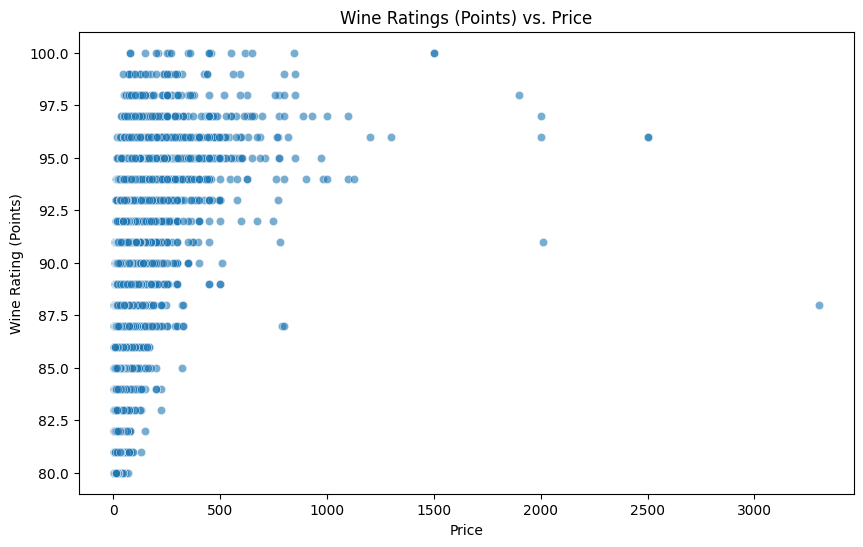

Pearson Correlation (Price vs. Points): 0.41616674186066566
p-value: 0.0


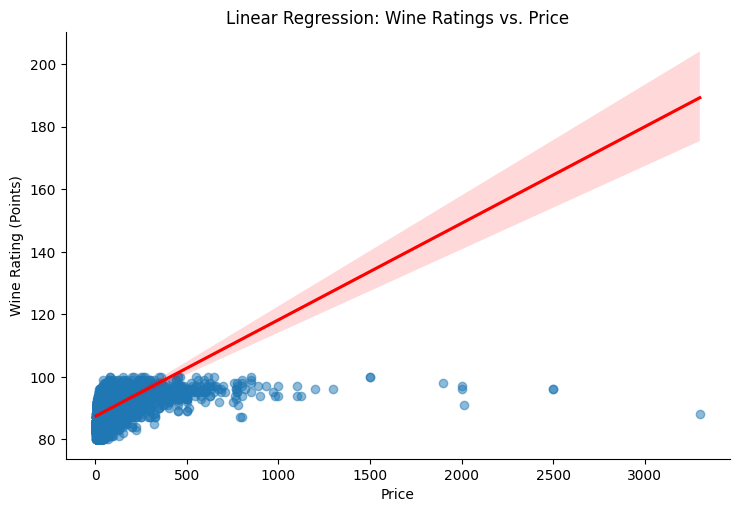

In [35]:
# Ensure that the price column is numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with missing price values
df_price = df.dropna(subset=['price'])

# Display summary statistics for the price column
print("Price Summary:")
print(df_price['price'].describe())

# Scatter plot: Ratings (points) vs. Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='price', y='points', data=df_price, alpha=0.6)
plt.title("Wine Ratings (Points) vs. Price")
plt.xlabel("Price")
plt.ylabel("Wine Rating (Points)")
plt.show()

# Compute Pearson correlation between price and points
corr_price, p_value_price = pearsonr(df_price['price'], df_price['points'])
print("Pearson Correlation (Price vs. Points):", corr_price)
print("p-value:", p_value_price)

# Plot a linear regression line using lmplot with red line
sns.lmplot(x='price', y='points', data=df_price, aspect=1.5,
           scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Linear Regression: Wine Ratings vs. Price")
plt.xlabel("Price")
plt.ylabel("Wine Rating (Points)")
plt.show()